In [1]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
import pyEPR as epr

In [2]:
design = designs.DesignPlanar()

In [3]:
design.overwrite_enabled = True
design.chips.main
design.chips.main.size.size_x = '2cm'
design.chips.main.size.size_y = '10mm'
gui = MetalGUI(design)

In [4]:
design.variables['cpw_width'] = '.1mm'
design.variables['cpw_gap'] = '.1mm'

## LAYOUT
---

In [5]:
from qiskit_metal.qlibrary.tlines import meandered, straight_path, framed_path
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.couplers.line_tee import LineTee

In [6]:
thru=False # only build transmission line
bias=False # build DC bias

In [7]:
"""
Transmission Line In/Out Ports 
"""
port_1_options = Dict(pos_x='-1cm',pos_y='0.0cm',width=design.variables['cpw_width'],orientation='180')
port_1_termination = OpenToGround(design,'Port1_Termination',options=port_1_options)

port_2_options = Dict(pos_x='1cm',pos_y='0.0cm',width=design.variables['cpw_width'],orientation='0')
port_2_termination = OpenToGround(design,'Port2_Termination',options=port_2_options)

In [301]:
if not thru:
    """
    Transmission Line Tee
    """
    tee1_options = Dict( pos_x="0cm",pos_y="0.0cm",rotation='0',coupling_length='2.5mm',
                         down_length='.5mm',fillet='.04cm',coupling_space='3um',
                         prime_width=design.variables['cpw_width'], second_width=design.variables['cpw_width'],
                         prime_gap=design.variables['cpw_gap'], 
                         second_gap='1mm' #design.variables['cpw_gap'] 
                         )
    tee1 = CoupledLineTee(design, "CouplingTee",options=tee1_options)

In [302]:
CoupledLineTee.get_template_options(design)

{'prime_width': '10um',
 'prime_gap': '6um',
 'second_width': '10um',
 'second_gap': '6um',
 'coupling_space': '3um',
 'coupling_length': '100um',
 'down_length': '100um',
 'fillet': '25um',
 'pos_x': '0um',
 'pos_y': '0um',
 'rotation': '0',
 'mirror': False,
 'open_termination': True,
 'chip': 'main',
 'layer': '1',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False}

In [303]:
"""
Transmission Line Thru
"""
if thru:
    straighta_tline_options = Dict( pin_inputs = Dict(  start_pin=Dict(component='Port1_Termination', pin='open'),
                                                        end_pin=Dict(component='Port2_Termination', pin='open')))
    straighta_tline = straight_path.RouteStraight(design,'straighta_tline', options=straighta_tline_options)
else:
#     straighta_tline_options = Dict( pin_inputs = Dict(  start_pin=Dict(component='Port1_Termination', pin='open'),
#                                                         end_pin=Dict(component='CouplingTee', pin='prime_start')))
#     straighta_tline = straight_path.RouteStraight(design,'straighta_tline', options=straighta_tline_options)

#     straightb_tline_options = Dict( pin_inputs = Dict(  start_pin=Dict(component='CouplingTee', pin='prime_end'),
#                                                         end_pin=Dict(component='Port2_Termination', pin='open')))
#     straightb_tline = straight_path.RouteStraight(design,'straightb_tline', options=straightb_tline_options)
    straighta_tline_options = Dict( pin_inputs = Dict(  start_pin=Dict(component='Port1_Termination', pin='open'),
                                                        end_pin=Dict(component='CouplingTee', pin='prime_start')),
                                                        lead=Dict(start_straight='.25cm',end_straight='.35cm'),
                                                        meander=Dict(spacing=".45mm"),
                                                        fillet = '105.00um', total_length = '2cm')
    straighta_tline = meandered.RouteMeander(design,'straighta_tline', options=straighta_tline_options)

    straightb_tline_options = Dict( pin_inputs = Dict(  start_pin=Dict(component='CouplingTee', pin='prime_end'),
                                                        end_pin=Dict(component='Port2_Termination', pin='open')),
                                                        lead=Dict(start_straight='.35cm',end_straight='.25cm'),
                                                        meander=Dict(spacing=".45mm"),
                                                        fillet = '105.00um', total_length = '2cm')
    straightb_tline = meandered.RouteMeander(design,'straightb_tline', options=straightb_tline_options)

In [304]:
meandered.RouteMeander.get_template_options(design)

{'pin_inputs': {'start_pin': {'component': '', 'pin': ''},
  'end_pin': {'component': '', 'pin': ''}},
 'fillet': '0',
 'lead': {'start_straight': '0mm',
  'end_straight': '0mm',
  'start_jogged_extension': '',
  'end_jogged_extension': ''},
 'total_length': '7mm',
 'chip': 'main',
 'layer': '1',
 'trace_width': 'cpw_width',
 'meander': {'spacing': '200um', 'asymmetry': '0um'},
 'snap': 'true',
 'prevent_short_edges': 'true',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False}

In [305]:
if not thru:
    """
    Resonator Grounding
    """
    res_short_options = Dict(pos_x='1.25mm',pos_y='-4mm',orientation='-90')
    res_short = ShortToGround(design,'Res_short',options=res_short_options)
    """
    Resonator A
    """
    meanderA_options = Dict(
        pin_inputs = Dict(  start_pin=Dict(component='CouplingTee', pin='second_end'),
                            end_pin=Dict(component='Res_short', pin='short')), 
                            lead = Dict(start_straight='800um',end_straight='100um'),
                            meander=Dict(spacing=".45mm"),
                            total_length = '2.1cm', fillet = '99um', width=design.variables['cpw_width'])
    MeanderA = meandered.RouteMeander(design,'meanderA', options=meanderA_options)

In [306]:
if not thru and bias:
    """
    DC bias Tee
    """
    dc_tee_options = Dict(  pos_x='2.625cm', pos_y='-1.mm',mirror=False,t_length='200um',
                            prime_width=design.variables['cpw_width'], orientation='-90', 
                            second_width=design.variables['cpw_width'] )
    dc_tee=LineTee(design, "DcTee",options=dc_tee_options)
    """
    DC Bias Pad
    """
    port_3_options = Dict(pos_x='0mm',pos_y='-1cm',orientation='0') # control
    port_3_termination = LaunchpadWirebondCoupled(design,'Port3_Termination',options=port_3_options)
    """
    DC Bias Line
    """
    control_line_options = Dict( pin_inputs=Dict(   start_pin=Dict(component='DcTee', pin='second_end'),
                                                    end_pin=Dict(component='Port3_Termination', pin='tie')),
                                                    total_length = '1mm', fillet = '105.00um',
                                                    width=design.variables['cpw_width'],)
    ControlLine=framed_path.RouteFramed(design,'controlline',options=control_line_options)

In [307]:
gui.rebuild()
gui.zoom_on_components([port_1_termination.name, port_2_termination.name])

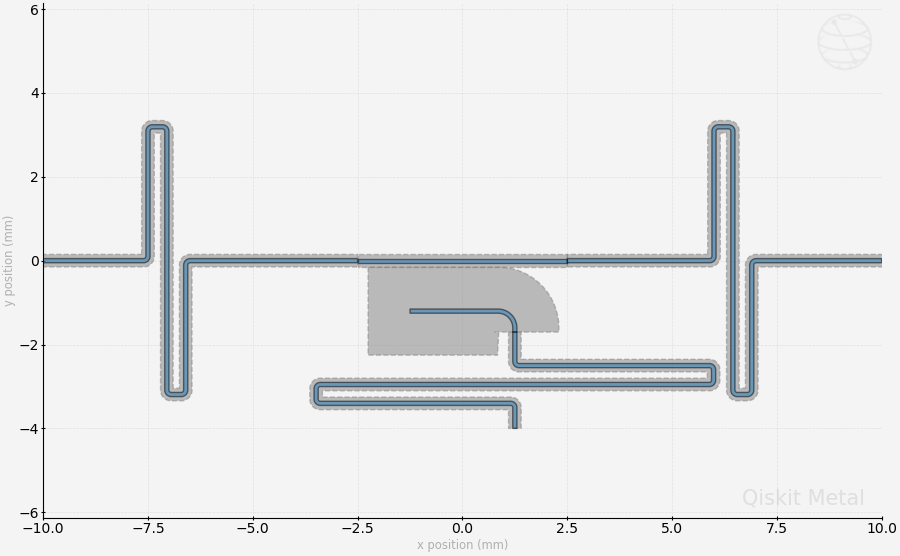

In [308]:
gui.figure.savefig('tline.png')
from IPython.display import Image, display
_disp_ops = dict(width=500)
display(Image('tline.png', **_disp_ops))

# GDS

In [291]:
a_gds = design.renderers.gds
a_gds.options['short_segments_to_not_fillet']=False
a_gds.options['check_short_segments_by_scaling_fillet']=1.0
a_gds.options['bounding_box_scale_y']=1.6
#a_gds.get_template_options(design)

In [292]:
a_gds.export_to_gds("ext-res.gds")

01:05PM 43s WARNING [_import_junctions_to_one_cell]: Not able to find file:"../resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"C:\Users\Undergrad\Downloads\qiskit-design-main (2)\resources".
01:05PM 43s WARNING [_cheese_buffer_maker]: The bounding box for no-cheese is outside of chip size.
Bounding box for chip is (-10.0, -5.0, 10.0, 5.0).
Bounding box with no_cheese buffer is (-10.031, -4.025, 10.031, 3.3675995789999997).


1

# Analysis

In [ ]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")
hfss = em1.renderer

In [ ]:
hfss.start()

In [ ]:
hfss.activate_ansys_design("Tline-Resonator2","drivenmodal")

In [ ]:
hfss.options['x_buffer_width_mm'] = 0.0
hfss.options['y_buffer_width_mm'] = 1.5

In [ ]:
hfss.clean_active_design()

In [ ]:
# example: update single setting
em1.setup.max_passes = 12
em1.setup.sweep_setup.stop_ghz = .1
em1.setup.sweep_setup.stop_ghz = 8
# example: update multiple settings
em1.setup_update(max_delta_s = 0.15, freq_ghz = 5.2)

In [ ]:
em1.run(name="SingleTM", components=['straighta_tline','straightb_tline',"CouplingTee","meanderA"], open_terminations=[], 
        port_list=[('Port1_Termination', 'open', 50), ('Port2_Termination', 'open', 50)],
        jj_to_port=[], box_plus_buffer = True)

In [ ]:
em1.start()
em1.renderer

In [ ]:
hfss.analyze_sweep('Sweep', 'Setup')

In [ ]:
hfss.plot_params(['S11', 'S21'])